<p style="font-size:32px"> 
    <b>Personalized cancer diagnosis</b> 
</p>

## Description

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>

## Data

<p> :: Memorial Sloan Kettering Cancer Center (MSKCC) :: </p>

There are nine different classes a genetic mutation can be classified on.

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

> <b> Some of the test data is machine-generated to prevent hand labeling.</b>


- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

## Real-world/Business objectives and constraints

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from pathlib import Path

<h2> Reading Data</h2>

<h3> Reading Gene and Variation Data</h3>

In [50]:
path = Path('../data/cancer_diagnosis')
list(path.iterdir())

[PosixPath('../data/cancer_diagnosis/msk-redefining-cancer-treatment.zip'),
 PosixPath('../data/cancer_diagnosis/stage1_solution_filtered.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_sample_submission.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_text.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_variants.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage_2_private_solution.csv.7z'),
 PosixPath('../data/cancer_diagnosis/test_text'),
 PosixPath('../data/cancer_diagnosis/test_text.zip'),
 PosixPath('../data/cancer_diagnosis/test_variants'),
 PosixPath('../data/cancer_diagnosis/test_variants.zip'),
 PosixPath('../data/cancer_diagnosis/training_text'),
 PosixPath('../data/cancer_diagnosis/training_text.zip'),
 PosixPath('../data/cancer_diagnosis/training_variants'),
 PosixPath('../data/cancer_diagnosis/training_variants.zip')]

<h3> Reading the variants Data</h3>

In [51]:
df_variants = pd.read_csv(path/'training_variants')
print(f"Number of data points and features:: {df_variants.shape}")
df_variants.head()

Number of data points and features:: (3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>
</p>

<h3> Reading the text Data</h3>

In [52]:
# !head -n 2 {path/'training_text'}

In [53]:
df_text = pd.read_csv(path/'training_text', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=1)
print(f"Number of data points and features:: {df_text.shape}")
df_text.head()


Number of data points and features:: (3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [54]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def text_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+', ' ', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
            if word not in stop_words:
                string += word + " "
        df_text[column][index] = string

In [55]:
#text processing stage.
start_time = time.clock()
for index, row in df_text.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print(f'There is no test for row:: {index}')
print(f"Time took for preprocessing the text:: {time.clock() - start_time}")

There is no test for row:: 1109
There is no test for row:: 1277
There is no test for row:: 1407
There is no test for row:: 1639
There is no test for row:: 2755
Time took for preprocessing the text:: 671.928035


In [89]:
df_final = pd.merge(df_variants, df_text, on='ID', how='left')
print(f"Number of data points and features:: {df_final.shape}")
df_final.head()

Number of data points and features:: (3321, 5)


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [90]:
df_final[df_final.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [91]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [92]:
df_final.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,3321,NaN,NaN,NaN,1660,958.834,0,830,1660,2490,3320
Gene,3321,264,BRCA1,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variation,3321,2996,Truncating Mutations,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,3321,NaN,NaN,NaN,4.36585,2.30978,1,2,4,7,9
TEXT,3316,1920,pten phosphatase tensin homolog phosphatase un...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df_final.loc[df_final['TEXT'].isnull(), 'TEXT'] = df_final.Gene + ' ' + df_final.Variation


In [96]:
df_final[df_final.ID == 2755]

,ID,Gene,Variation,Class,TEXT
2755,2755,BRAF,G596C,7,BRAF G596C


In [97]:
df_final.sample(10)

,ID,Gene,Variation,Class,TEXT
2808,2808,BRCA2,K2411T,6,mutation screening breast ovarian cancer predi...
895,895,PDGFRA,Y375_K455del,7,gene rearrangement form intragenic deletion pr...
2047,2047,SOS1,R552G,7,noonan syndrome common single gene cause conge...
794,794,ERBB4,N181S,3,recent efforts comprehensively characterize mu...
665,665,CDKN2A,G35R,4,inherited mutations affecting ink4a arf locus ...
2895,2895,BRCA2,M2676T,6,twenty percent individuals strong family perso...
44,44,PTPRT,T1365M,4,tyrosine phosphorylation regulated protein tyr...
3005,3005,KIT,D816V,7,introduction mastocytosis comprises spectrum d...
250,250,EGFR,I853T,4,purpose epidermal growth factor receptor egfr ...
1229,1229,PIK3CB,D1067A,7,activation pi3k pathway occurs commonly wide v...


<h3> Test, Train and Cross Validation Split</h3>

<h4> Splitting data into train, test and cross validation [64:20:16] </h4>

In [101]:
y_true = df_final['Class'].values
df_final.Gene = df_final.Gene.str.replace('\s+', '_')
df_final.Variation = df_final.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(df_final, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)


In [102]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4> Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

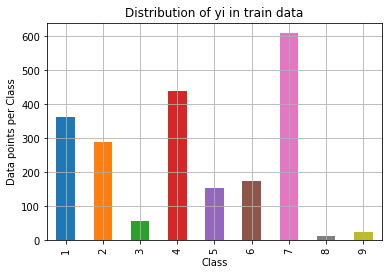

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


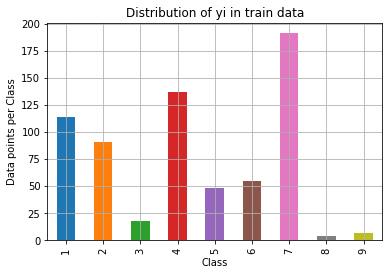

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


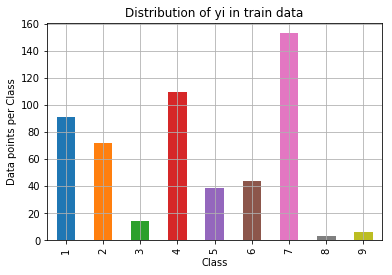

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [106]:
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()


my_colors = 'rgbkymc'

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
print("=" * 100)


test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')
print("=" * 100)

cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')
print("=" * 100)

<h3> Prediction using a <span style="color:blue">Random</span> Model</h3>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [107]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = (C.T / C.sum(axis=1)).T
    
    B = C / C.sum(axis=0)
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print(":"*20, "Confusion matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print(":"*20, "Precision matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print(":"*20, "Recall matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
                

Log loss on Cross Validation Data using Random Model 2.47640907898673
Log loss on Test Validation Data using Random Model 2.4703634454425085
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


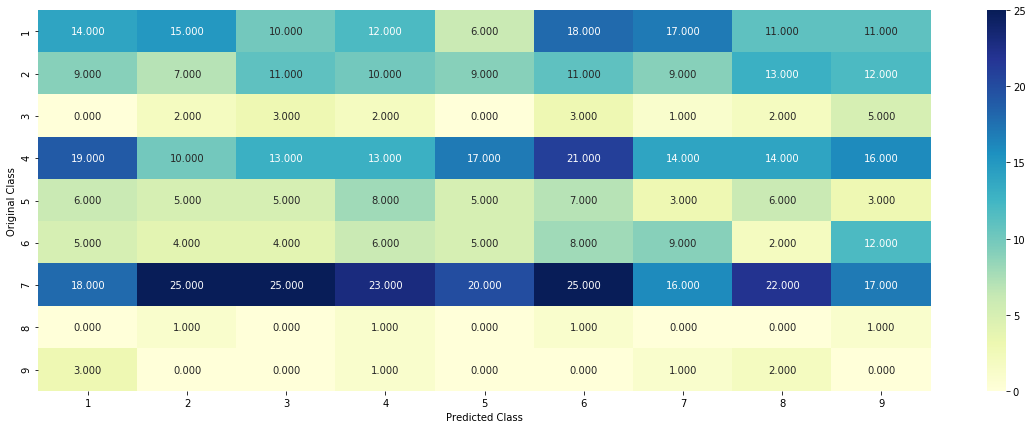

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


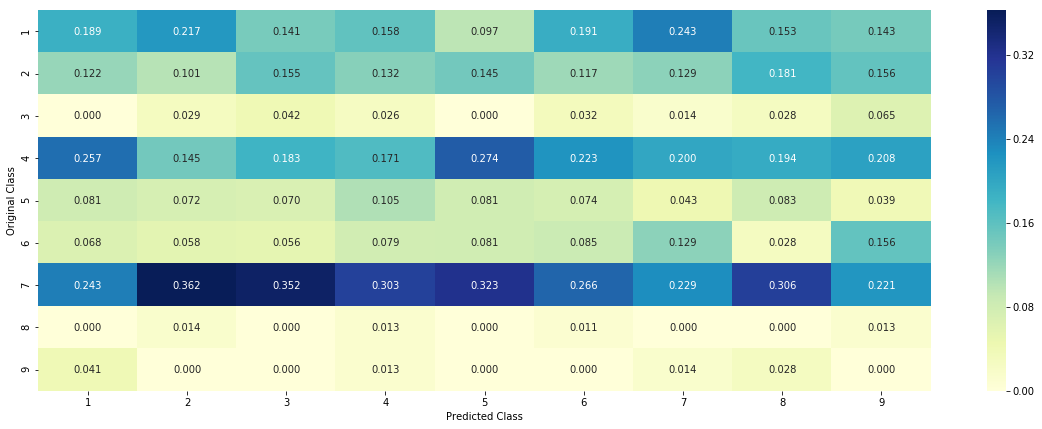

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


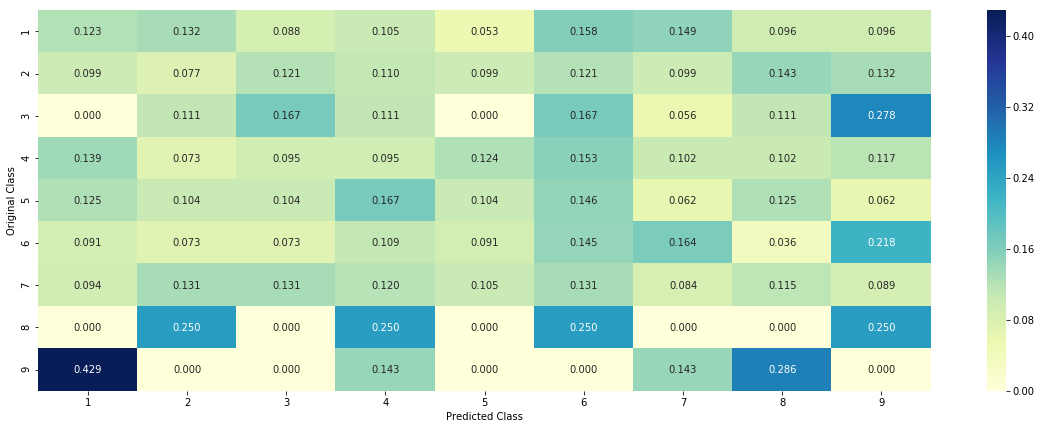

In [108]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len, 9))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 9)
    cv_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv, cv_predicted_y, eps=1e-15))

    
test_predicted_y = np.zeros((test_data_len, 9))

for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    test_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Test Validation Data using Random Model",log_loss(y_test, test_predicted_y, eps=1e-15))


predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)



### Submission

In [114]:
df_variants_test = pd.read_csv(path/'test_variants', names=df_variants.columns)
print(f"Number of data points and features:: {df_variants_test.shape}")
df_variants_test.head()

Number of data points and features:: (368, 4)


,ID,Gene,Variation,Class
0,0,CBL,H398Q,4
1,1,CBL,S80N,6
2,2,SHOC2,M173I,4
3,3,DICER1,D1709N,4
4,4,PTPRT,S492F,1


In [115]:
df_text_test = pd.read_csv(path/'test_text', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=0)
print(f"Number of data points and features:: {df_text_test.shape}")
df_text_test.head()

Number of data points and features:: (368, 2)


,ID,TEXT
0,0,Oncogenic mutations in the monomeric Casitas B...
1,1,Abstract Background Non-small cell lung canc...
2,2,Rasopathies are phenotypically similar syndrom...
3,3,Abstract DICER1 plays a critical role in mic...
4,4,The receptor protein tyrosine phosphatase T (P...


In [116]:
df_final_test = pd.merge(df_variants_test, df_text_test, on='ID', how='left')
df_final_test.shape

(368, 5)

In [113]:
df_text_test = pd.read_csv(path/'sub', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=0)
print(f"Number of data points and features:: {df_text_test.shape}")
df_text_test.head()

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')